In [1]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()

[]

In [2]:
import json
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, GRU, LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D, MaxPooling1D
from keras.utils import np_utils
import itertools
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sys, os
import traceback
from itertools import chain
import numpy as np
import pandas as pd

import tensorflow as tf
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [3]:
def get_sentences(data_list):
    sentences = []
    for a in data_list.article.unique():
        words = []
        prev_n = 0
        for _,s in data_list.loc[data_list.article == a].iterrows():
            n = s['sentence_no']
            if n != prev_n:
                if len(words) > 2 and len(set([x[1] for x in words])) > 1:
                    sentences.append(words)
                words = []
            words.append((s['word'], s['encoding'], s['part_of_speech']))
            prev_n = n
            
        if len(words) > 2 and len(set([x[1] for x in words])) > 1:
            sentences.append(words)
            
    return sentences

In [4]:
data_list = pd.read_csv('../data/go/go_cc3.csv')
data_list.word.fillna('NA', inplace=True)

# temp = pd.read_csv('../data/go_bpmf_2.0_more.csv')
# temp.word.fillna('NA', inplace=True)

# data_list = data_list.merge(temp, on=['article', 'sentence_no', 'word_no'])
# data_list.sort_values(['article', 'sentence_no'], kind='mergesort', inplace=True)
# x_counts = data_list.encoding_x.value_counts()
# y_counts = data_list.encoding_y.value_counts()
# data_list['encoding_x'] = data_list.encoding_x.apply(lambda x: x if x_counts[x] > 4 else 'O')
# data_list['encoding_y'] = data_list.encoding_y.apply(lambda x: x if y_counts[x] > 4 else 'O')
# data_list['encoding'] = [i if i != 'O' else j for i,j in zip(data_list.encoding_x, data_list.encoding_y)]
# data_list = data_list.rename(columns={'word_x' : 'word'})

In [5]:
data_list = get_sentences(data_list)
print(data_list[0])
print(len(data_list))

words = list(set(y[0] for x in data_list for y in x))
n_words = len(words)
print(n_words)

tags = list(set(y[1] for x in data_list for y in x))
n_tags = len(tags)
print(n_tags)

poss = list(set(y[2] for x in data_list for y in x))
n_poss = len(poss)
print(n_poss)

[('CAF-1', 'GO:0033186', 'NNP'), ('Is', 'O', 'VBZ'), ('Essential', 'O', 'NNP'), ('for', 'O', 'IN'), ('Heterochromatin', 'GO:0000792', 'NNP'), ('Organization', 'O', 'NNP'), ('in', 'O', 'IN'), ('Pluripotent', 'O', 'NNP'), ('Embryonic', 'O', 'NNP'), ('Cells', 'O', 'NNP')]
2598
8890
456
43


In [6]:
max_len = 75
max_len_char = 10

word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["O"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["O"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

pos2idx = {w: i+1 for i, w in enumerate(poss)}
pos2idx["X"] = 0
idx2pos = {i: w for w, i in pos2idx.items()}

In [7]:
print(tag2idx)

{'1_GO:0016323': 1, '1_GO:0005769': 417, '2_GO:0005759': 231, 'GO:0005840': 163, 'GO:0042611': 448, '1_GO:0017053': 232, '2_GO:0060076': 2, '2_GO:0034399': 233, '1_GO:0005720': 3, '1_GO:0005640': 339, '1_GO:0005794': 234, '2_GO:1990351': 4, '1_GO:0045098': 418, 'GO:0005712': 5, '3_GO:0034683': 6, '1_GO:0001917': 7, 'GO:0042995': 8, 'GO:0005819': 236, '4_GO:0044853': 9, '2_GO:0005610': 237, 'GO:0043226': 11, 'GO:1990794': 239, '1_GO:1990351': 12, '2_GO:0012506': 78, '1_GO:0034399': 240, '1_GO:0005714': 101, 'GO:0005886': 13, 'GO:0000786': 14, 'GO:0044444': 383, '2_GO:0001741': 15, '2_GO:0005714': 244, 'GO:0031143': 245, '2_GO:0005960': 16, '2_GO:0055037': 17, 'GO:0005829': 246, 'GO:0019814': 247, '1_GO:0045254': 18, '1_GO:0060076': 19, '1_GO:0043679': 248, 'GO:0042555': 20, '2_GO:0034675': 21, '2_GO:0016323': 253, '2_GO:0097440': 380, '2_GO:0005913': 22, '2_GO:0017053': 23, '2_GO:0005667': 255, 'GO:0005901': 24, 'GO:0009986': 258, '2_GO:0009898': 259, '2_GO:0070161': 25, '2_GO:1990876':

In [8]:
print(pos2idx)

{'IN': 1, 'JJR': 15, ':': 2, 'PRP$': 3, 'VBG': 5, 'VB': 6, "''": 28, 'VBN': 7, 'CC': 4, 'UH': 8, 'PDT': 32, 'TO': 9, 'VBZ': 39, '.': 10, 'VBD': 42, 'JJS': 12, 'MD': 13, '(': 14, 'PRP': 16, 'POS': 17, 'NN': 18, 'WRB': 19, 'X': 0, 'EX': 21, 'RB': 11, 'WP': 23, 'JJ': 25, ',': 27, 'WDT': 29, ')': 26, 'DT': 30, '$': 31, '``': 34, 'RP': 33, 'FW': 35, 'RBR': 36, 'NNPS': 37, 'CD': 38, 'WP$': 24, 'RBS': 20, 'NNS': 40, '#': 41, 'NNP': 22, 'VBP': 43}


In [9]:
X_word = [[w[0] for w in s] for s in data_list]
new_X = []
for seq in X_word:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("ENDPAD")
    new_X.append(new_seq)
X_word = new_X

In [10]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

111


In [11]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["O"] = 0

In [12]:
X_char = []
for sentence in data_list:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("O"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))


In [14]:
from keras.preprocessing.sequence import pad_sequences
X_pos = [[pos2idx[w[2]] for w in s] for s in data_list]
X_pos = pad_sequences(maxlen=max_len, sequences=X_pos, value=pos2idx["X"], padding='post', truncating='post')

In [15]:
y = [[tag2idx[w[1]] for w in s] for s in data_list]
y = pad_sequences(maxlen=max_len, sequences=y,value=tag2idx["O"], padding='post', truncating='post')

In [16]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags+1) for i in y]

In [17]:
from sklearn.model_selection import train_test_split
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.3, random_state=2018)
X_pos_tr, X_pos_te, _, _ = train_test_split(X_pos, y, test_size=0.3, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.3, random_state=2018)

In [18]:
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
sess = tf.Session()
K.set_session(sess)
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(32*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.


In [19]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D, Flatten
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D, Lambda

# input and embedding for words
word_in = Input(shape=(max_len,), dtype=tf.string)

emb_word = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(word_in)

# input and embedding for parts of speech
pos_in = Input(shape=(max_len,))
emb_pos = Embedding(input_dim=n_poss + 1, output_dim=len(pos2idx),
                     input_length=max_len, mask_zero=True)(pos_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=100,
                           input_length=max_len_char, mask_zero=True))(char_in)


dropout = Dropout(0.3)(emb_char)

char_enc = TimeDistributed(GRU(units=150, return_sequences=False,
                                recurrent_dropout=0.5))(dropout)

# main GRU
x = concatenate([emb_word, char_enc, emb_pos])
main_gru = Bidirectional(GRU(units=200, return_sequences=True,
                             dropout=0.5,
                               recurrent_dropout=0.25))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(main_gru)

model = Model([word_in, pos_in, char_in], out)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [20]:
from keras.optimizers import RMSprop

rmsopt = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer=rmsopt, loss="categorical_crossentropy", metrics=["acc"])

In [21]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 75, 10)       0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 75, 10, 100)  11300       input_3[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 75)           0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 75, 10, 100)  0           time_distributed_1[0][0]         
__________________________________________________________________________________________________
input_2 (I

In [22]:
from keras.utils import plot_model
plot_model(model, to_file='../data/output/graphs/GRU-Elmo.png')

In [ ]:
# history = model.fit([X_word_tr,
#                      np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
#                     np.array(y_tr).reshape(len(y_tr), max_len, 1),
#                     batch_size=32, epochs=15, validation_data=([X_word_te,
#                      np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))],
#                     np.array(y_te).reshape(len(y_te), max_len, 1)),
#                     verbose=1)
history = model.fit([X_word_tr[:len(X_word_tr)//32*32], X_pos_tr[:len(X_word_tr)//32*32],
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))[:len(X_word_tr)//32*32]],
                    np.array(y_tr[:len(X_word_tr)//32*32]),
                    batch_size=32, epochs=15, validation_data=([X_word_te[:len(y_te)//32*32], X_pos_te[:len(y_te)//32*32],
                     np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))[:len(y_te)//32*32]],
                    np.array(y_te[:len(y_te)//32*32])),
                    verbose=1)

Train on 1792 samples, validate on 768 samples
Epoch 1/15
1792/1792 [==============================] - 309s 172ms/step - loss: 0.4936 - acc: 0.9308 - val_loss: 0.2912 - val_acc: 0.9640
Epoch 2/15
1792/1792 [==============================] - 352s 196ms/step - loss: 0.2159 - acc: 0.9661 - val_loss: 0.1863 - val_acc: 0.9719
Epoch 3/15
1792/1792 [==============================] - 553s 309ms/step - loss: 0.1517 - acc: 0.9757 - val_loss: 0.1639 - val_acc: 0.9783
Epoch 4/15
1792/1792 [==============================] - 558s 311ms/step - loss: 0.1135 - acc: 0.9805 - val_loss: 0.1403 - val_acc: 0.9800
Epoch 5/15
1792/1792 [==============================] - 554s 309ms/step - loss: 0.0880 - acc: 0.9841 - val_loss: 0.1241 - val_acc: 0.9825
Epoch 6/15
1792/1792 [==============================] - 553s 309ms/step - loss: 0.0684 - acc: 0.9868 - val_loss: 0.1134 - val_acc: 0.9839
Epoch 7/15
1792/1792 [==============================] - 551s 307ms/step - loss: 0.0542 - acc: 0.9890 - val_loss: 0.1063 - val

In [28]:
hist = pd.DataFrame(history.history)
hist.to_csv('../data/results/performance/GO_GRU-Elmo.tsv', sep='\t')

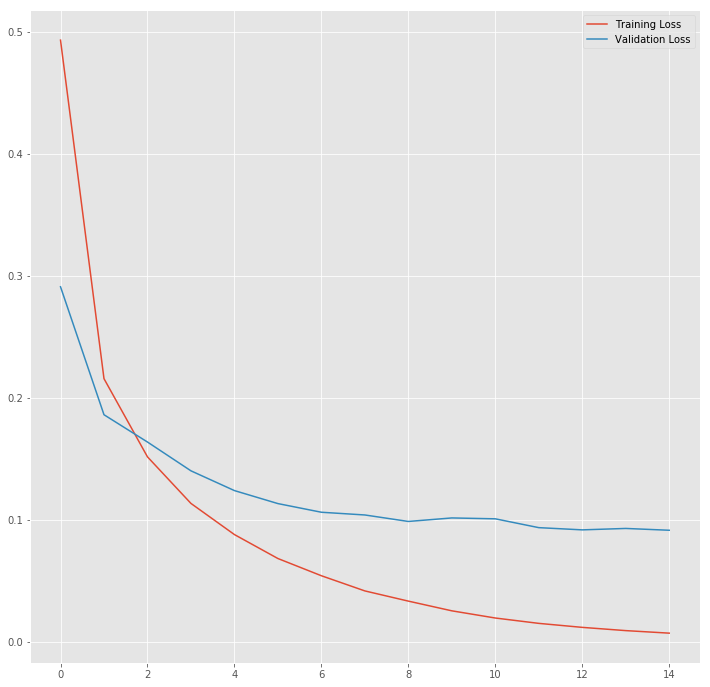

In [29]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"], label='Training Loss')
plt.plot(hist["val_loss"], label='Validation Loss')
plt.legend()
plt.show()

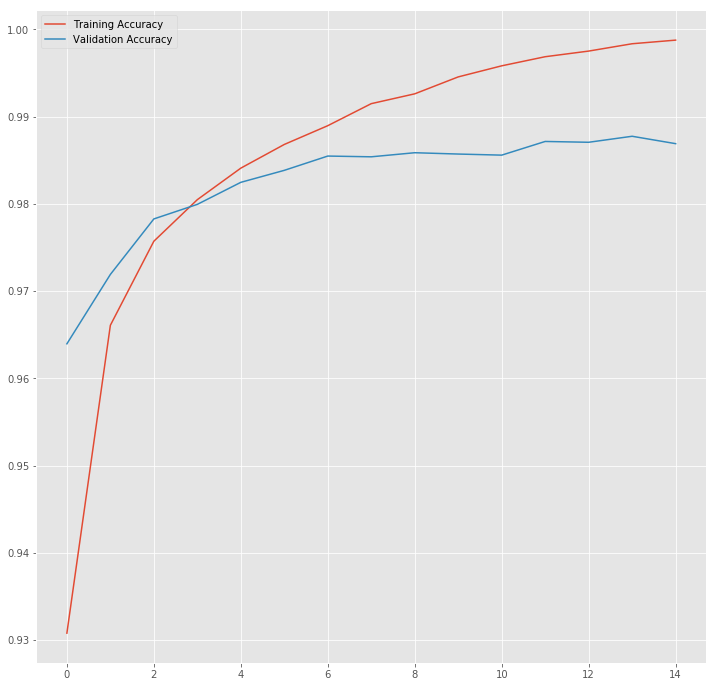

In [30]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"], label='Training Accuracy')
plt.plot(hist["val_acc"], label='Validation Accuracy')
plt.legend()
plt.show()

In [32]:
from sklearn.metrics import classification_report

predicted = model.predict([X_word_te[:len(y_te)//32*32], X_pos_te[:len(y_te)//32*32],
                        np.array(X_char_te[:len(y_te)//32*32]).reshape((len(X_char_te[:len(y_te)//32*32]),
                                                     max_len, max_len_char))])
true = []
predicted_val = []
word = []
for i in range(len(predicted)):
    p_tmp = np.argmax(predicted[i], axis=-1)
    t_tmp = np.argmax(y_te[i], -1)
    word.append(X_word_te[i])
    predicted_val.append(p_tmp)
    true.append(t_tmp)

wd = [list(map(lambda x: y, y)) for y in word]    
p = [list(map(lambda x: idx2tag[x], y)) for y in predicted_val]
t = [list(map(lambda x: idx2tag[x], y)) for y in true]

report = classification_report(list(itertools.chain.from_iterable(t)), 
                                    list(itertools.chain.from_iterable(p)))
# print "\n"
print(report)

              precision    recall  f1-score   support

1_GO:0000790       0.00      0.00      0.00         1
1_GO:0000795       1.00      1.00      1.00         4
1_GO:0000800       0.33      1.00      0.50         1
1_GO:0000803       1.00      1.00      1.00         3
1_GO:0000805       1.00      1.00      1.00         8
1_GO:0000806       1.00      1.00      1.00         2
1_GO:0001739       0.75      1.00      0.86         9
1_GO:0001741       0.96      1.00      0.98        22
1_GO:0001750       0.92      1.00      0.96        24
1_GO:0001917       0.88      1.00      0.93         7
1_GO:0005615       0.00      0.00      0.00         1
1_GO:0005634       0.89      1.00      0.94         8
1_GO:0005643       0.00      0.00      0.00         1
1_GO:0005657       1.00      0.50      0.67         2
1_GO:0005667       1.00      1.00      1.00         1
1_GO:0005675       1.00      1.00      1.00         2
1_GO:0005714       0.00      0.00      0.00         1
1_GO:0005721       0.80    

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [34]:
i = 300
pred = np.argmax(predicted[i], axis=-1)
print(pred)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, tr, pred in zip(X_word_te[i], np.argmax(y_te[i], -1), pred):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w], idx2tag[tr], idx2tag[pred]))
        
# pd = model.predict(np.array([X_te[i]]))
# pd = np.argmax(pd, axis=-1)
# true = np.argmax(y_te[i], -1)
# print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
# print(30 * "=")

# for w, t1, pred in zip(X_te[i], true, pd[0]):
#     if w != 0:
#         print("{:15}: {:5} {}".format(words[w-1], tags[t1], tags[pred]))

[  0   0   0   0   0  69   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0 319   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
Word           ||True ||Pred


TypeError: list indices must be integers or slices, not str

In [33]:
import pandas as pd

df = pd.DataFrame(
{
    'Predicted' : list(itertools.chain.from_iterable(p)),
    'Ground Truth': list(itertools.chain.from_iterable(t)),
    'Word' : list(itertools.chain.from_iterable(wd)),
}
)


In [35]:
df = df[df['Word'] != 'O']

In [36]:
df1 = df[(df['Predicted'] != 'O') & (df['Ground Truth'] != 'O') | 
         (df['Predicted'] == 'O') & (df['Ground Truth'] != 'O') |
         (df['Predicted'] != 'O') & (df['Ground Truth'] == 'O')
        ]

report = classification_report(df1['Ground Truth'], 
                                    df1['Predicted'])
print("\n")
print(report)



              precision    recall  f1-score   support

1_GO:0000790       0.00      0.00      0.00         1
1_GO:0000795       1.00      1.00      1.00         4
1_GO:0000800       0.33      1.00      0.50         1
1_GO:0000803       1.00      1.00      1.00         3
1_GO:0000805       1.00      1.00      1.00         8
1_GO:0000806       1.00      1.00      1.00         2
1_GO:0001739       0.75      1.00      0.86         9
1_GO:0001741       0.96      1.00      0.98        22
1_GO:0001750       0.92      1.00      0.96        24
1_GO:0001917       0.88      1.00      0.93         7
1_GO:0005615       0.00      0.00      0.00         1
1_GO:0005634       0.89      1.00      0.94         8
1_GO:0005643       0.00      0.00      0.00         1
1_GO:0005657       1.00      0.50      0.67         2
1_GO:0005667       1.00      1.00      1.00         1
1_GO:0005675       1.00      1.00      1.00         2
1_GO:0005714       0.00      0.00      0.00         1
1_GO:0005721       0.80  

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
